## MACD

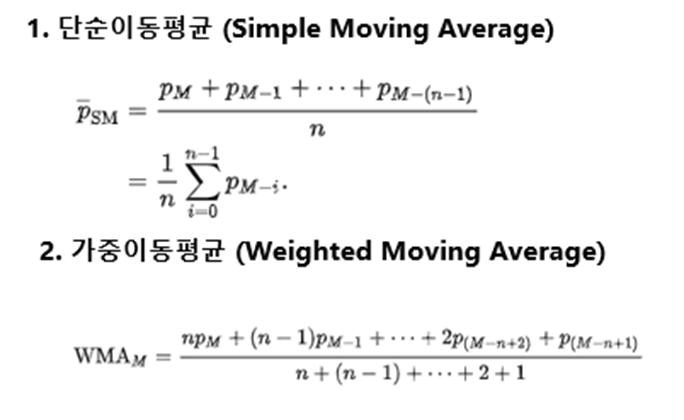

1. **MACD곡선** : 12일 지수이평선 - 26일 지수이평선
2. **MACD시그널** : MACD곡선의 9일 지수이평선
3. **MACD히스토그램** : MACD곡선 - MACD시그널

In [ ]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import json

In [ ]:
stock2code = json.load(open('../data/stock2code.json', 'r'))
df = fdr.DataReader(stock2code['SK하이닉스'], '2015')

ewm12w = df.Close.ewm(span=60).mean()   #12주 이평선
ewm26w = df.Close.ewm(span=130).mean() #26주 이평선
macdline = ewm12w - ewm26w  #macd곡선
macdsign = macdline.ewm(span=45).mean()  #macd시그널
macdhist = macdline - macdsign  #macd히스토그램

### matplotlib으로 MACD 시각화

In [ ]:
plt.figure(figsize=(14,10))

plt.subplot(2,1,1)
plt.plot(df.Close)

plt.subplot(2,1,2)
plt.plot(macdline, label='macdline')
plt.plot(macdsign, label='macdsign')
plt.bar(macdhist.index, macdhist, label='macdhist')
plt.legend()
plt.show()

### plotly로 MACD시각화

In [ ]:
total_df = pd.concat([df, ewm12w, ewm26w, macdline, macdsign, macdhist], axis=1).dropna()
total_df.columns = df.columns.tolist() + ['EWM12W','EWM26W','MACDLINE','MACDSIGN','MACDHIST']
total_df.tail()

In [ ]:
import cufflinks as cf
from plotly.offline import iplot
cf.go_offline(connected=True)

qplot = cf.QuantFig(total_df, title='MACD', legend='top', name='MACD')

In [ ]:
qplot.add_ema(periods=130, column='Close', color='red')
qplot.add_volume(column='MACDHIST', name='MACD-HIST')
qplot.add_macd(60, 130, 45)
qplot.iplot()

## 볼린저밴드

In [ ]:
df = fdr.DataReader(stock2code['SK하이닉스'], '2020')
df

In [ ]:
df['MA20'] = df.Close.rolling(window=20).mean() # 20일 이평선
df['STD'] = df.Close.rolling(window=20).std()   # 20일 이동표준편차
df['UB'] = df.MA20 + df.STD * 2    # upper band
df['LB'] = df.MA20 - df.STD * 2    # lower band
df.dropna(inplace=True)
df

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df.Close, label='Close')
plt.plot(df.index, df.UB, linestyle='--', label='Upper Band')
plt.plot(df.index, df.LB, linestyle='--', label='Lower Band')
plt.plot(df.index, df.MA20, label='MA20')
plt.fill_between(df.index, df.UB, df.LB, color='grey', alpha=0.2)
plt.legend()
plt.show()

### %b

In [ ]:
df = fdr.DataReader(stock2code['SK하이닉스'], '2020')
df['MA20'] = df.Close.rolling(window=20).mean() # 20일 이평선
df['STD'] = df.Close.rolling(window=20).std()   # 20일 이동표준편차
df['UB'] = df.MA20 + df.STD * 2
df['LB'] = df.MA20 - df.STD * 2
df['pct_b'] = (df.Close - df.LB) / (df.UB - df.LB)
df.dropna(inplace=True)
df

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(211)
plt.plot(df.index, df.Close, label='Close')
plt.plot(df.index, df.UB, linestyle='--', label='Upper Band')
plt.plot(df.index, df.LB, linestyle='--', label='Lower Band')
plt.plot(df.index, df.MA20, label='MA20')
plt.fill_between(df.index, df.UB, df.LB, color='grey', alpha=0.2)
plt.legend()


plt.subplot(212)
plt.plot(df.index, df.pct_b, label='%b', color='red')
plt.legend()
plt.show()

### band width

In [ ]:
df = fdr.DataReader(stock2code['SK하이닉스'], '2020')
df['MA20'] = df.Close.rolling(window=20).mean() # 20일 이평선
df['STD'] = df.Close.rolling(window=20).std()
df['UB'] = df.MA20 + df.STD * 2
df['LB'] = df.MA20 - df.STD * 2
df['pct_b'] = (df.Close - df.LB) / (df.UB - df.LB)
df['bw'] = (df.UB - df.LB) / df.MA20  * 100
df.dropna(inplace=True)


plt.figure(figsize=(14,5))
plt.subplot(211)
plt.plot(df.index, df.Close, label='Close')
plt.plot(df.index, df.UB, linestyle='--', label='Upper Band')
plt.plot(df.index, df.LB, linestyle='--', label='Lower Band')
plt.plot(df.index, df.MA20, label='MA20')
plt.fill_between(df.index, df.UB, df.LB, color='grey', alpha=0.2)
plt.legend()


plt.subplot(212)
plt.plot(df.index, df.bw, label='band_width', color='red')
plt.legend()
plt.show()

### trend-follwing

- %b > 0.8 and MFI > 80 : **Long**
- %b < 0.2 and MFI < 20 : **Short**

- MFI = 100 - (100 / (1 + PMF/NMF) )

- 중심가격(typical Price) : High, Low, Close의 평균
- 현금흐름(Money Flow) : Typical Price * Volume
- PMF : 중심가격이 전일보다 상승한 날들의 MF의 합
- NMF : 중심가격이 전일보다 하락한 날들의 MF의 합

In [ ]:
df['TP'] = (df.High + df.Low + df.Close) / 3
df['PMF'] = 0
df['NMF'] =  0 

In [ ]:
for i in range(len(df.Close)-1):
    if df.TP.values[i] < df.TP.values[i+1]:
        df.PMF.values[i+1] = df.TP.values[i+1] * df.Volume.values[i+1]
        df.NMF.values[i+1] = 0 
        
    elif df.TP.values[i] > df.TP.values[i+1]:
        df.NMF.values[i+1] = df.TP.values[i+1] * df.Volume.values[i+1]
        df.PMF.values[i+1] = 0 

In [ ]:
df['MFI'] = 100 - 100 / ( 1 + df.PMF.rolling(20).sum() / df.NMF.rolling(20).sum())

In [ ]:
df.dropna(inplace=True)

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(211)
plt.plot(df.index, df.Close, label='Close')
plt.plot(df.index, df.UB, linestyle='--', label='Upper Band')
plt.plot(df.index, df.LB, linestyle='--', label='Lower Band')
plt.plot(df.index, df.MA20, label='MA20')
plt.fill_between(df.index, df.UB, df.LB, color='grey', alpha=0.2)
plt.legend()

plt.subplot(212)
plt.plot(df.index, df.MFI, label='MFI', color='red')
plt.legend()
plt.show()

- %b > 0.8 and MFI > 80 : **Long**
- %b < 0.2 and MFI < 20 : **Short**

In [ ]:
#LONG 조건에 해당하는 data 조회
df.loc[df.pct_b > 0.8].loc[df.MFI > 80]

In [ ]:
#SHORT 조건에 해당하는 data 조회
df.loc[df.pct_b < 0.2].loc[df.MFI < 20]